In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
/device:GPU:0
Found GPU at: /device:GPU:0


#***Division of the Dataset***

In [ ]:
!pip install split-folders tqdm

In [ ]:
import splitfolders
import os
from google.colab import drive
drive.mount('/content/drive')


datadir='/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_images'
datasplit='/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten'

#split with the ratio of 0.8 for training set, 0.1 for validation set, 0.1 for test set.
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_images", output="/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]

Mounted at /content/drive


Copying files: 8745 files [45:52,  3.18 files/s]


# ***Load Data***

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten'
trainingset = datadir+'/train'
testset = datadir+'/test'
valset = datadir+'/val'

batch_size = 32

#train_datagen = ImageDataGenerator(
#    rescale = 1. / 255)

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)


val_datagen = ImageDataGenerator(
    rescale = 1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=valset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples_train = train_generator.n
num_samples_val = val_generator.n
num_samples_test = test_generator.n

num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples_train,num_classes))
print('Loaded %d validating samples from %d classes.' %(num_samples_val,val_generator.num_classes))
print('Loaded %d test samples from %d classes.' %(num_samples_test,test_generator.num_classes))


Mounted at /content/drive
Found 6992 images belonging to 8 classes.
Found 871 images belonging to 8 classes.
Found 882 images belonging to 8 classes.
Image input (118, 224, 3)
Classes: ['Dust_Mops_&_Pads', 'Figs', 'Nuts_snacks', 'Seltzer_Water', 'food_tray', 'fruit_plate', 'instant_Soup', 'plastic_knife']
Loaded 6992 training samples from 8 classes.
Loaded 871 validating samples from 8 classes.
Loaded 882 test samples from 8 classes.


#***Show random images***

fruit_plate


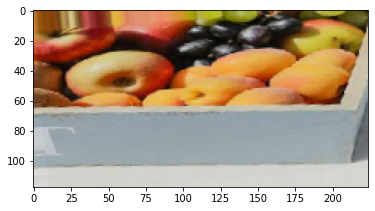

Seltzer_Water


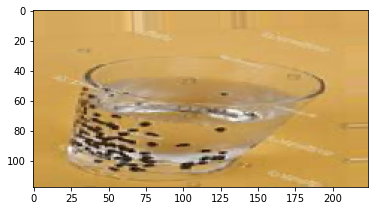

Seltzer_Water


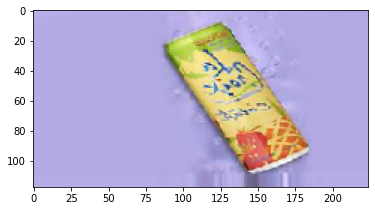

In [ ]:
import matplotlib.pyplot as plt

n=3

x,y = train_generator.next()

for i in range(0,n):
  image=x[i]
  label=y[i].argmax()
  print(classnames[label])
  plt.imshow(image)
  plt.show()
  

#***Load base VGG16 model***

In [ ]:
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks
import pickle 


# Load VGG16 model 
# init_weights='imagenet' if you want to use the pretrained model


def load_vgg16_features(input_shape, init_weights=None):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load VGG16 model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam' #alternative 'sgd'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 118, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 118, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 118, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 59, 112, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 59, 112, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 59, 112, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 29, 56, 128)    

#***VGG16-TransferNet***

In [ ]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    # add a Dense layer
    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam' #alternative 'sgd'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
tran_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
tran_model.summary()

Model: "transferNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 118, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 118, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 118, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 59, 112, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 59, 112, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 59, 112, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 29, 56, 128)       

#***Train VGG16-ARGOS***

In [ ]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size+1

epochs = 20
try:
    history = tran_model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=val_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Epoch 1/20
218/218 [==============================] - 2052s 9s/step - loss: 1.4663 - accuracy: 0.5053 - val_loss: 0.9924 - val_accuracy: 0.6739
Epoch 2/20
218/218 [==============================] - 57s 263ms/step - loss: 0.8873 - accuracy: 0.6847 - val_loss: 0.8115 - val_accuracy: 0.7095
Epoch 3/20
218/218 [==============================] - 57s 263ms/step - loss: 0.7850 - accuracy: 0.7318 - val_loss: 0.7621 - val_accuracy: 0.7566
Epoch 4/20
218/218 [==============================] - 57s 262ms/step - loss: 0.7077 - accuracy: 0.7510 - val_loss: 0.7448 - val_accuracy: 0.7555
Epoch 5/20
218/218 [==============================] - 57s 262ms/step - loss: 0.6574 - accuracy: 0.7681 - val_loss: 0.7323 - val_accuracy: 0.7566
Epoch 6/20
218/218 [==============================] - 57s 262ms/step - loss: 0.6483 - accuracy: 0.7790 - val_loss: 0.7436 - val_accuracy: 0.7681
Epoch 7/20
218/218 [==============================] - 57s 262ms/step - loss: 0.6018 - accuracy: 0.7915 - val_loss: 0.7420 - val_acc

#***SAVE***

In [ ]:
import os

models_dir = datadir + '/models/'

def savemodel(tran_model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    tran_model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(tran_model,'TransferNet_20_epochs_noAug')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten/models/TransferNet_20_epochs_noAug.h5



#***load a trained model***

In [ ]:
import os
from keras.models import load_model

models_dir = datadir + '/models/'

def loadmodel(problem):
  filename = os.path.join(models_dir, '%s.h5' %problem)
  try:
    model=load_model(filename)
    print("\nModel loaded successfully from file %s \n" %filename)
  except OSError:
    print("\nModel file %s not found!!! \n" %filename)
    model=None
  return model

tran_model = loadmodel('TransferNet_20_epochs')


Model loaded successfully from file /content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten/models/TransferNet_20_epochs.h5 



#***Evaluate the model***

In [ ]:
val_steps = test_generator.n//test_generator.batch_size+1
loss, acc = tran_model.evaluate(test_generator, verbose=1, steps=val_steps)
print('Test Loss: %f' %loss)
print('Test Accuracy: %f' %acc)

28/28 [==============================] - 371s 13s/step - loss: 0.7291 - accuracy: 0.7891
Test Loss: 0.729077
Test Accuracy: 0.789116


***Precision, Recall, F-score***

Found 882 images belonging to 8 classes.
28/28 [==============================] - 2s 85ms/step
                  precision    recall  f1-score   support

Dust_Mops_&_Pads      0.888     0.853     0.870       102
            Figs      0.852     0.868     0.860       106
     Nuts_snacks      0.811     0.624     0.705       117
   Seltzer_Water      0.854     0.800     0.826       110
       food_tray      0.713     0.694     0.703       111
     fruit_plate      0.661     0.689     0.675       122
    instant_Soup      0.723     0.879     0.793       107
   plastic_knife      0.856     0.944     0.898       107

        accuracy                          0.789       882
       macro avg      0.795     0.794     0.791       882
    weighted avg      0.792     0.789     0.788       882



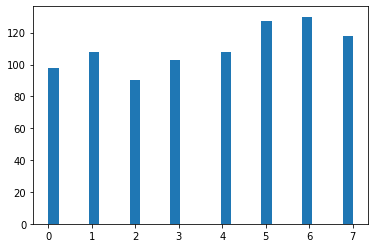

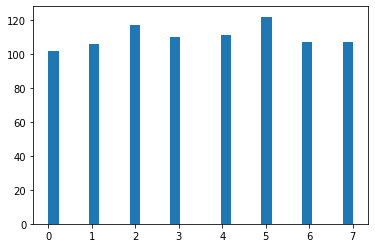

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = tran_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Ypred, 30)
plt.show()

plt.hist(Ytest, 30)
plt.show()

***Confusion matrix analysis***

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = tran_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))


Found 882 images belonging to 8 classes.
 1/28 [>.............................] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


28/28 [==============================] - 2s 87ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Nuts_snacks      ->  instant_Soup      	17 	1.93 % 
food_tray        ->  fruit_plate       	16 	1.81 % 
fruit_plate      ->  food_tray         	15 	1.70 % 
Nuts_snacks      ->  fruit_plate       	13 	1.47 % 
Figs             ->  Nuts_snacks       	10 	1.13 % 
Dust_Mops_&_Pads ->  plastic_knife     	8 	0.91 % 
fruit_plate      ->  instant_Soup      	7 	0.79 % 
food_tray        ->  Nuts_snacks       	7 	0.79 % 
fruit_plate      ->  Nuts_snacks       	6 	0.68 % 
instant_Soup     ->  fruit_plate       	6 	0.68 % 
Seltzer_Water    ->  instant_Soup      	6 	0.68 % 
Seltzer_Water    ->  food_tray         	6 	0.68 % 
instant_Soup     ->  Seltzer_Water     	6 	0.68 % 
fruit_plate      ->  Seltzer_Water     	5 	0.57 % 
Nuts_snacks      ->  food_tray         	5 	0.57 % 
fruit_plate      ->  Dust_Mops_&_Pads  	4 	0.45 % 
Sel

In [ ]:
import numpy as np
import pandas as pd
import random
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=plt.cm.Blues):
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, no normalization'
  cm = confusion_matrix(y_true, y_pred)
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
  else:
    pass
    
  
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)

  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='true label', xlabel='predicted label')
  

  ax.set_ylim(len(classes)-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  

  fmt= '.2f' if normalize else 'd'
  thresh=cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j]>thresh else "black")
  fig.tight_layout()
  return ax


print('Libraries imported.')

Libraries imported.


[[87  1  0  1  4  1  0  8]
 [ 1 87 10  0  0  4  3  1]
 [ 0  3 76  2  5 13 17  1]
 [ 4  3  2 82  6  4  6  3]
 [ 2  0  7  3 80 16  3  0]
 [ 4  1  6  5 15 82  7  2]
 [ 0  0  0  6  1  6 94  0]
 [ 3  2  0  0  3  1  0 98]]


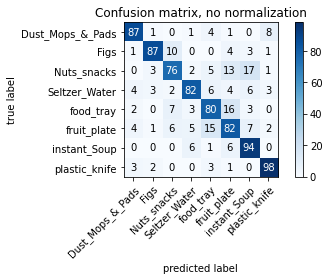

In [ ]:
#CONFUSION MATRIX
cm= confusion_matrix(Ytest, Ypred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(Ytest, Ypred, classnames, normalize=False)

#***Plot results***

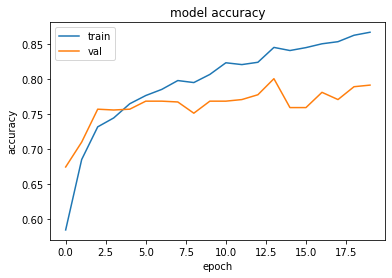

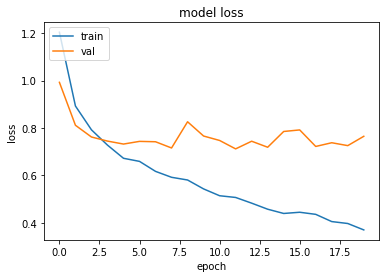

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()